In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Camera Calibration
# Prepare object points (3D world coordinates)
objp = np.zeros((9 * 6, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Lists to store object points and image points
objpoints = []  # 3D points
imgpoints = []  # 2D points

for i in range(1, 4):
    img = cv2.imread(f"firstCam/image{i}.jpg")
    if img is None:
        print(f"Could not load image: {i}")
        continue
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

# Perform camera calibration after collecting all points
if objpoints and imgpoints:
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
else:
    raise ValueError("No calibration data found!")

# Step 2: Load Images and Extract Features
img1 = cv2.imread('test1.jpg')
img2 = cv2.imread('test3.jpg')
img1_undist = cv2.undistort(img1, K, dist)
img2_undist = cv2.undistort(img2, K, dist)
img1_gray = cv2.cvtColor(img1_undist, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2_undist, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1_gray, None)
kp2, des2 = sift.detectAndCompute(img2_gray, None)

# Step 3: Match Features
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
if len(good_matches) < 8:
    raise ValueError("Not enough matches found!")

pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Step 4: Compute Fundamental and Essential Matrices
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
print(" Fundemental Matrix : ", F )

pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]
E = K.T @ F @ K

# Step 5: Recover Camera Pose
_, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)

# Step 6: Triangulate Points
P1 = np.hstack([np.eye(3), np.zeros((3, 1))])
P2 = np.hstack([R, t])
pts1_h = np.hstack([pts1.reshape(-1, 2), np.ones((pts1.shape[0], 1))])
pts2_h = np.hstack([pts2.reshape(-1, 2), np.ones((pts2.shape[0], 1))])

points_3d_h = cv2.triangulatePoints(P1, P2, pts1.reshape(-1, 2).T, pts2.reshape(-1, 2).T)
points_3d = points_3d_h[:3] / points_3d_h[3]


# Step 7: Projective reconstruction
# Normalize the 3D points
mean = np.mean(points_3d, axis=1)
std = np.std(points_3d, axis=1)
scale = 1 / std
translate = -mean * scale

# Create a 4x4 transformation matrix
T = np.eye(4)
T[:3, :3] = np.diag(scale)  # Scaling part
T[:3, 3] = translate         # Translation part

# Convert to homogeneous coordinates
points_3d_homogeneous = np.vstack([points_3d, np.ones(points_3d.shape[1])])

# Apply transformation
points_3d_normalized_homogeneous = T @ points_3d_homogeneous

# Convert back to non-homogeneous
points_3d_normalized = points_3d_normalized_homogeneous[:3] / points_3d_normalized_homogeneous[3]

# Visualize the 3D points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_normalized[0], points_3d_normalized[1], points_3d_normalized[2], c='b', marker='.')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


ValueError: No calibration data found!

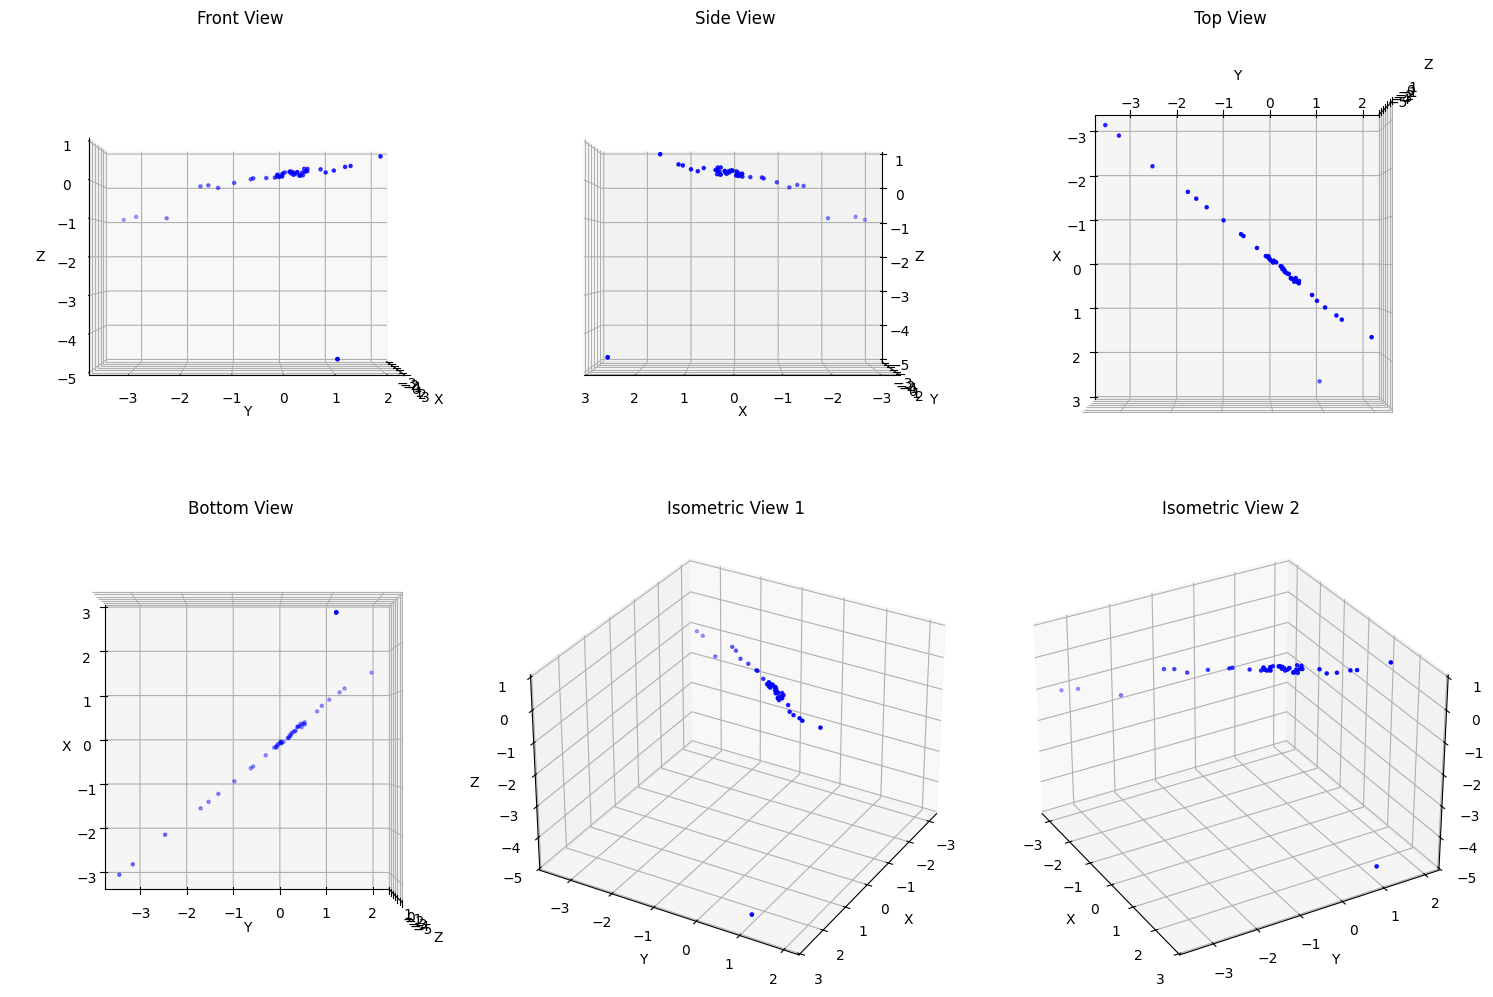

In [ ]:
# Visualize the 3D points from different views
fig = plt.figure(figsize=(15, 10))

# View 1: Front view
ax1 = fig.add_subplot(231, projection='3d')
ax1.scatter(points_3d_normalized[0], points_3d_normalized[1], points_3d_normalized[2], c='b', marker='.')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.view_init(elev=0, azim=0)
ax1.set_title('Front View')

# View 2: Side view
ax2 = fig.add_subplot(232, projection='3d')
ax2.scatter(points_3d_normalized[0], points_3d_normalized[1], points_3d_normalized[2], c='b', marker='.')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.view_init(elev=0, azim=90)
ax2.set_title('Side View')

# View 3: Top view
ax3 = fig.add_subplot(233, projection='3d')
ax3.scatter(points_3d_normalized[0], points_3d_normalized[1], points_3d_normalized[2], c='b', marker='.')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.view_init(elev=90, azim=0)
ax3.set_title('Top View')

# View 4: Bottom view
ax4 = fig.add_subplot(234, projection='3d')
ax4.scatter(points_3d_normalized[0], points_3d_normalized[1], points_3d_normalized[2], c='b', marker='.')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Z')
ax4.view_init(elev=-90, azim=0)
ax4.set_title('Bottom View')

# View 5: Isometric view 1
ax5 = fig.add_subplot(235, projection='3d')
ax5.scatter(points_3d_normalized[0], points_3d_normalized[1], points_3d_normalized[2], c='b', marker='.')
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.set_zlabel('Z')
ax5.view_init(elev=30, azim=30)
ax5.set_title('Isometric View 1')

# View 6: Isometric view 2
ax6 = fig.add_subplot(236, projection='3d')
ax6.scatter(points_3d_normalized[0], points_3d_normalized[1], points_3d_normalized[2], c='b', marker='.')
ax6.set_xlabel('X')
ax6.set_ylabel('Y')
ax6.set_zlabel('Z')
ax6.view_init(elev=30, azim=-30)
ax6.set_title('Isometric View 2')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

# Step 1: Load original images
img1 = cv2.imread('test1.jpg')  # Load first image (where pts1 originated)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Step 2: Extract colors from img1 at pts1 locations
pts1_int = np.round(pts1[:, 0, :]).astype(int)  # Convert to integer pixel coordinates
img_colors = np.zeros((points_3d.shape[1], 3))  # Initialize color array

for i, (x, y) in enumerate(pts1_int):
    if 0 <= x < img1.shape[1] and 0 <= y < img1.shape[0]:  # Check bounds
        img_colors[i] = img1[y, x] / 255.0  # Normalize RGB values to [0,1]

# Step 3: Convert points and colors to Open3D format
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d.T)
pcd.colors = o3d.utility.Vector3dVector(img_colors)

# Step 4: Estimate normals
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Step 5: Poisson surface reconstruction
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

# Step 6: Assign extracted colors to the Poisson mesh
mesh.vertex_colors = o3d.utility.Vector3dVector(img_colors)

# Step 7: Remove low-density vertices (optional filtering)
vertices_to_remove = densities < np.quantile(densities, 0.05)  # Remove lowest 5% density points
mesh.remove_vertices_by_mask(vertices_to_remove)

# Step 8: Visualize the dense colored mesh
o3d.visualization.draw_geometries([mesh])


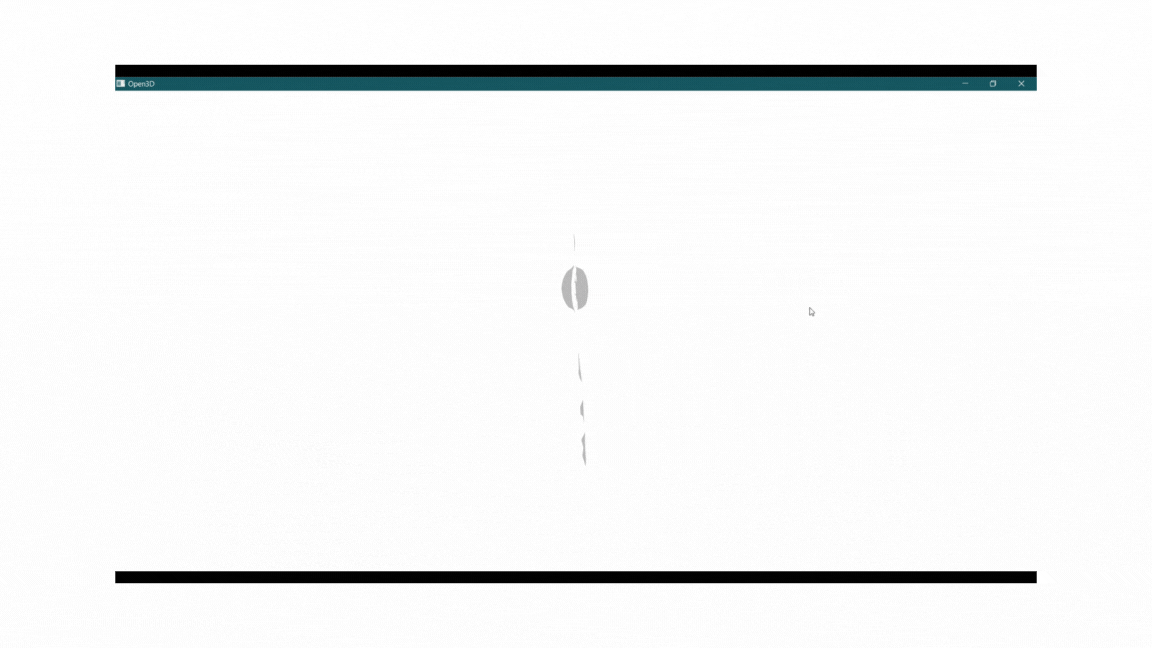

In [ ]:
import os
from IPython.display import display, Image

# Set folder path
folder_path = "outputs"  # Change this to your folder path

# Get all image files
image_extensions = (".png", ".jpg", ".jpeg", ".gif")
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)]

# Display images
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    display(Image(filename=image_path))